# Imports & Settings

In [2]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
import glob
import shutil
from IPython.display import clear_output, display

dataset_folder = "/home/sara/Desktop/Master-thesis/dataset"
yolo_folder = "/home/sara/Desktop/Master-thesis/yolov5"

%cd {yolo_folder}
!git clone https://github.com/ultralytics/yolov5  # clone

# Image size 
w_image,h_image = 768, 768
pixels = w_image*h_image

/home/sara/Desktop/Master-thesis/yolov5
fatal: destination path 'yolov5' already exists and is not an empty directory.


# Divide Boat/No boat images

In [ ]:
# Settings
images_path = f"{dataset_folder}/train_set"

In [3]:
destination_path_boats = f"{dataset_folder}/only_boats/images/"
destination_path_no_boats = f"{dataset_folder}/no_boats/images/"

tmp  = destination_path_boats.strip("images/")
if not os.path.exists(tmp):
  os.makedirs(tmp)
  print(f"'{tmp}' directory is created!")
tmp  = destination_path_no_boats.strip("images/")
if not os.path.exists(tmp):
  os.makedirs(tmp)
  print(f"'{tmp}' directory is created!")
if not os.path.exists(destination_path_boats):
  os.makedirs(destination_path_boats)
  print(f"'{destination_path_boats}' directory is created!")
if not os.path.exists(destination_path_no_boats):
  os.makedirs(destination_path_no_boats)
  print(f"'{destination_path_no_boats}' directory is created!")

dataset_csv = f"{dataset_folder}/train_ship_segmentations_v2.csv"

df = pd.read_csv(dataset_csv)
df.head()

max = df.shape[0]

for index, row in df.iterrows():
    mask = row["EncodedPixels"]

    img_path = os.path.join(images_path,row['ImageId'])
    img_path_boats = os.path.join(destination_path_boats,row['ImageId'])
    img_path_no_boats = os.path.join(destination_path_no_boats,row['ImageId'])

    # Check boat or not boat
    if os.path.isfile(img_path) and not pd.isna(mask) and not os.path.isfile(img_path_boats):
        shutil.copy(img_path, destination_path_boats)
    elif os.path.isfile(img_path)and pd.isna(mask) and not os.path.isfile(img_path_no_boats):
        shutil.copy(img_path, destination_path_no_boats)
       
    # Print
    if index % 1000 == 0:
        clear_output()
        display(f"{index}/{max}")
        
clear_output()
display(f"{max}/{max}")

'231723/231723'

# Convert 
From semantic segmentation masks from Kaggle into yolo images and masks folders

## Import masks from csv-file
run-length-encoding

In [4]:
dataset_csv = os.path.join(dataset_folder,"train_ship_segmentations_v2.csv")

df = pd.read_csv(dataset_csv)
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


## Functions

In [5]:
def calculate_mask(line):
    if not pd.isna(line):
        # Create mask
        mask = np.zeros(pixels, dtype="uint8")
        line = line.split(" ")
        pair = []
        for value in line:
            pair.append(int(value))
            if len(pair) == 2:
                start = pair[0]
                end = start + pair[1]
                mask[start:end] = 1
                pair = []
        mask = mask.reshape(h_image,w_image)
        mask = np.rot90(mask, k=1)
        mask = np.flip(mask, axis=0)
        return mask
    return None

def calculate_bounding_box(mask, mode=None):
    if mask is not None:
        # Create bounding box
        x,y,w,h = cv2.boundingRect(mask)
        centerx = int(x+(w/2))
        centery = int(y+(h/2))

        if mode == "percentage":
            centerx = centerx/w_image
            centery = centery/h_image
            w = w/w_image
            h = h/h_image

        return f"0 {centerx} {centery} {w} {h}"

    return None

## Tests

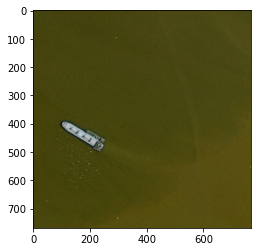

In [6]:
img_path = os.path.join(dataset_folder, "images_one", "0a0df8299.jpg")

image = cv2.imread(img_path)
plt.imshow(image)

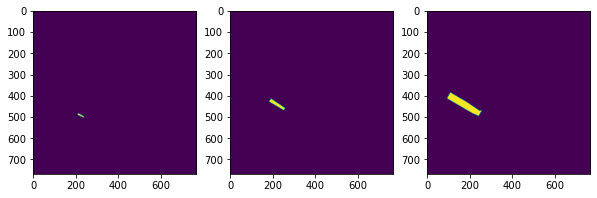

In [12]:
# get masks of image
one = df[df['ImageId'] == "0a0df8299.jpg"]["EncodedPixels"].values[0]
two = df[df['ImageId'] == "0a0df8299.jpg"]["EncodedPixels"].values[1]
three = df[df['ImageId'] == "0a0df8299.jpg"]["EncodedPixels"].values[2]
masks = [calculate_mask(one), calculate_mask(two), calculate_mask(three)]

fig, axs = plt.subplots(1, len(masks), figsize=(10, 3))

for ax, mask in zip(axs, masks):
    ax.imshow(mask)

plt.show()

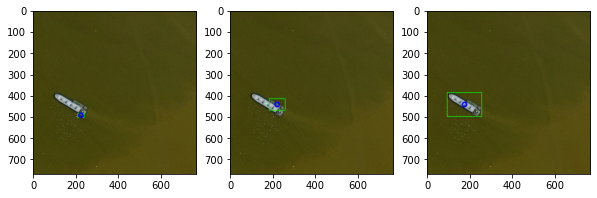

In [15]:
# Get bounding box
fig, axs = plt.subplots(1, len(masks), figsize=(10, 3))
conimages = []

for ax, mask in zip(axs, masks):
    conimage = image.copy()

    x,y,w,h = cv2.boundingRect(mask)
    centerx = int(x+(w/2))
    centery = int(y+(h/2))
    cv2.rectangle(conimage,(x,y),(x+w,y+h),(0,255,0),2)
    cv2.circle(conimage, (centerx,centery), 10, (0, 0, 255), 5)
    ax.imshow(conimage)
    conimages.append(conimage)

plt.show()

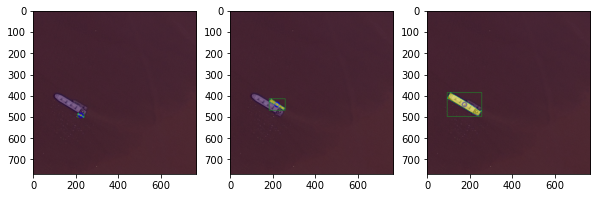

In [17]:
fig, axs = plt.subplots(1, len(masks), figsize=(10, 3))

for ax, mask , conimage in zip(axs, masks, conimages):
    ax.imshow(conimage)
    ax.imshow(mask, alpha=0.5)

plt.show()

## Convert

In [6]:
max = df.shape[0]
dataset = []

images_path = os.path.join(dataset_folder, "only_boats/images")
labels_path = os.path.join(dataset_folder, "only_boats/labels")

if not os.path.exists(labels_path):
  os.makedirs(labels_path)
  print(f"'{labels_path}' directory is created!")

for index, row in df.iterrows():
    # Check if file exist
    path = os.path.join(images_path,row['ImageId'])
    if os.path.isfile(path):
    
        # Create txt
        path = f"{os.path.join(labels_path, row['ImageId'].strip('.jpg'))}.txt"
        dataset.append(os.path.join(labels_path, row['ImageId']))
        file_object  = open(path, "a")

        # Create mask
        mask = calculate_mask(row["EncodedPixels"])

        # Calculate bounding box
        line = calculate_bounding_box(mask, mode="percentage")
        
        if line is not None:
            file_object.write(f"{line} \n")

        file_object.close()

    # Print
    if index % 1000 == 0:
        clear_output()
        display(f"{index}/{max}")
        
clear_output()
display(f"{max}/{max}")


'231723/231723'

# Divide dataset (test, train, val)
Into train, val and test txt files for yolov5 training. 

In [9]:
from sklearn.model_selection import train_test_split

path_data_images = os.path.join(dataset_folder, "train/images")
computer = "_sara"

path_train_file = os.path.join(yolo_folder,"datasets",f"{computer}train.txt")
path_val_file = os.path.join(yolo_folder,"datasets",f"{computer}val.txt")
path_test_file = os.path.join(yolo_folder,"datasets",f"{computer}test.txt")
path_all_file = os.path.join(yolo_folder,"datasets",f"{computer}all.txt")

files = os.listdir(path_data_images)

nr_of_images = len(files)

print(f"Number of files: {nr_of_images}")


Number of files: 100


In [10]:
X_train, X_val = train_test_split(files, test_size=0.7, shuffle=True)
X_val, X_test = train_test_split(X_val, test_size=0.5) # 0.15 per list

with open(path_all_file, "w") as output_all:

    with open(path_train_file, "w") as output:

        for file in X_train:
            output.write(f"{str(os.path.join(path_data_images, file))}\n")
            output_all.write(f"{str(os.path.join(path_data_images, file))}\n")
    output.close()
    
    with open(path_val_file, "w") as output:

        for file in X_val:
            output.write(f"{str(os.path.join(path_data_images, file))}\n")
            output_all.write(f"{str(os.path.join(path_data_images, file))}\n")
    output.close()

    with open(path_test_file, "w") as output:

        for file in X_test:
            output.write(f"{str(os.path.join(path_data_images, file))}\n")
            output_all.write(f"{str(os.path.join(path_data_images, file))}\n")
    output.close()
    
output_all.close()

# Other usefull scripts

## Move multiple items from one folder to another

In [ ]:
# Settings
nr_files_to_move = 100

images_path = "/media/ebara/46CC6137CC612303/train/images"
destination_path = "/media/ebara/46CC6137CC612303/val/images"

In [ ]:
files = os.listdir(images_path)

total_nr_files = len(files)
files_count = 0

for file in files:
    img_path = os.path.join(images_path, file)
    img_path_dest = os.path.join(destination_path, file)

    # Check if file already exist
    if not os.path.isfile(img_path_dest):
        shutil.move(img_path, img_path_dest)
        files_count +=1
    
    if files_count == nr_files_to_move:
        break

    # Print
    if index % 1000 == 0:
        clear_output()
        display(f"{index}/{max}")
        
clear_output()
display(f"{max}/{max}")

## Create folder

In [ ]:
directory = "/home/sara/Desktop/Master-thesis/master_thesis/Dataset/labels"
try:
    os.mkdir(directory)
    print("Directory '% s' created" % directory)
except:
    print("Directory '% s' is already created" % directory)

## Delete content in folder (CAUSION!)

In [ ]:
delete_in_folder = "/home/sara/Desktop/Master-thesis/master_thesis/Dataset/only_boats/labels/"

files = glob.glob(f"{delete_in_folder}/*")
for f in files:
    os.remove(f)